In [31]:
import pandas as pd
import numpy as np
import multiprocessing
from bs4 import BeautifulSoup as bs
from selectolax.parser import HTMLParser
import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import keyboard
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [32]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
# Data loading and preparation
data = pd.read_json('../datasets/dataset.json')
mapping = {False: 0, True: 1}
data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['violation'], axis=1, inplace=True)
data.shape

(86439, 2)

In [34]:
data.head()

,text,labels
0,My Favorite Slut,0
1,girlfriends sit on each other's faces with the...,0
2,bound beauty kisses her girlfriend,0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0
4,TRANSGENDER COACHING (wmv) PART 1,0


# Preprocessing function

In [35]:
def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', "'", '(', ')', ':', '-', '--', '', '?', '@', '....', '~',
                     '.', '..', '...', '<', '>', '=', '\'\'', '//', '»', '|', '’', '`', '+'
                     '\"\"', '</', '&', '/', '#', '\'', '*', '``', '%', '[', ']', '{', '}']

stop_words = stopwords.words('english') + ['14000kbps', "n't", "'s", "'m", 'mp4', 'error', '404']
morph = pymorphy2.MorphAnalyzer(lang='uk')

INFO - 16:59:28: Loading dictionaries from /Users/adwiz/venv310/lib/python3.10/site-packages/pymorphy2_dicts_uk/data
INFO - 16:59:28: format: 2.4, revision: 1, updated: 2016-04-10T11:08:15.982658


In [36]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

In [37]:
data[:1000].apply(lambda row: str(row.text), axis=1)

0                                       My Favorite Slut
1      girlfriends sit on each other's faces with the...
2                     bound beauty kisses her girlfriend
3      MORGAN - Anytime - Nail Painting On The Slave'...
4                      TRANSGENDER COACHING (wmv) PART 1
                             ...                        
995    Captain Next Fucks Hot Wife Laney On Her Husba...
996    Captain Next Fucks Hot Wife Laney On Her Husba...
997    Captain Next Fucks Hot Wife Laney On Her Husba...
998    XY19 - Sexy Chinese Maid Gets Femdom With Vibr...
999     The Strongest Reverse Headscissors Contest HDMP4
Length: 1000, dtype: object

In [38]:
data.head()

,text,labels
0,My Favorite Slut,0
1,girlfriends sit on each other's faces with the...,0
2,bound beauty kisses her girlfriend,0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0
4,TRANSGENDER COACHING (wmv) PART 1,0


In [39]:
data[:100].apply(lambda row: bs(row['text']).get_text().replace('\n',' '),axis=1)

0                                      My Favorite Slut
1     girlfriends sit on each other's faces with the...
2                    bound beauty kisses her girlfriend
3     MORGAN - Anytime - Nail Painting On The Slave'...
4                     TRANSGENDER COACHING (wmv) PART 1
                            ...                        
95    Real Mesmerized Housewife of Brooklyn follows ...
96              Kaylia strict hogtie naked on the floor
97                 Real Mesmerized Submissive Housewife
98                       EHESKLAVE MUSS FÜSSE LUTSCHEN!
99    Uncut, Buck Nekkid fucks and creampies Polly B...
Length: 100, dtype: object

In [40]:
data[:100].apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1) #, morph), axis=1)

0                                         favorite slut
1                           girlfriends sit faces asses
2                        bound beauty kisses girlfriend
3               morgan anytime nail painting slave face
4                       transgender coaching wmv part 1
                            ...                        
95    real mesmerized housewife brooklyn follows orders
96                     kaylia strict hogtie naked floor
97                 real mesmerized submissive housewife
98                        ehesklave muss füsse lutschen
99    uncut buck nekkid fucks creampies polly bundy ...
Length: 100, dtype: object

In [41]:
data['text_preprocessed'] = data.apply(lambda row: bs(row.text).get_text().replace('\n',' '),axis=1)
# data['text_preprocessed'] = data.apply(lambda row: HTMLParser(row.text).body.text(separator=' ').replace('\n',' '),axis=1)

In [42]:
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text_preprocessed, punctuation_marks, stop_words), axis=1)

In [43]:
data = data[['text_preprocessed', 'labels', 'text']] # columns reorder

In [44]:
data.head()

,text_preprocessed,labels,text
0,favorite slut,0,My Favorite Slut
1,girlfriends sit faces asses,0,girlfriends sit on each other's faces with the...
2,bound beauty kisses girlfriend,0,bound beauty kisses her girlfriend
3,morgan anytime nail painting slave face,0,MORGAN - Anytime - Nail Painting On The Slave'...
4,transgender coaching wmv part 1,0,TRANSGENDER COACHING (wmv) PART 1


# Tensorflow

In [45]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [46]:
counter = counter_word(data.text_preprocessed)  

In [47]:
data.text_preprocessed

0                                            favorite slut
1                              girlfriends sit faces asses
2                           bound beauty kisses girlfriend
3                  morgan anytime nail painting slave face
4                          transgender coaching wmv part 1
                               ...                        
86434    enought visit us social media sites updates ch...
86435                                                     
86436                                                     
86437                                                     
86438                                                     
Name: text_preprocessed, Length: 86439, dtype: object

In [48]:
num_unique_words = len(counter)

In [49]:
num_unique_words

73548

In [50]:
counter

Counter({'favorite': 383,
         'slut': 2088,
         'girlfriends': 187,
         'sit': 784,
         'faces': 284,
         'asses': 344,
         'bound': 1992,
         'beauty': 570,
         'kisses': 340,
         'girlfriend': 515,
         'morgan': 251,
         'anytime': 76,
         'nail': 454,
         'painting': 114,
         'slave': 6945,
         'face': 7114,
         'transgender': 124,
         'coaching': 8,
         'wmv': 1872,
         'part': 2706,
         '1': 1426,
         '2212terra-kept': 1,
         'tied': 2165,
         'gagged': 1716,
         'garage': 24,
         'cadence': 94,
         'gets': 1828,
         'catfished': 3,
         '2': 1803,
         '3': 959,
         'mobile': 309,
         'lick': 1541,
         'sexy': 7146,
         'mules': 154,
         'clean': 753,
         'shoe': 2121,
         'worship': 8542,
         'domination': 10286,
         'gorgeous': 672,
         'yet': 248,
         'hangry': 2,
         'amazonia

In [51]:
counter.most_common(5)

[('fetish', 25585),
 ('feet', 20641),
 ('foot', 19155),
 ('ass', 13228),
 ('big', 10813)]

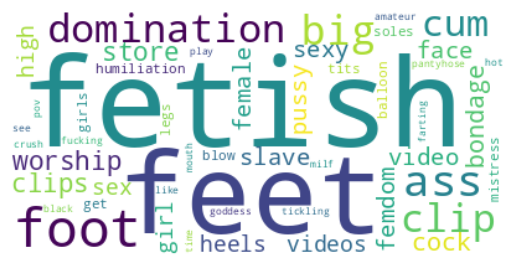

In [52]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [53]:
train_size = int(data.shape[0] * .8)

train = data[:train_size]
val = data[train_size:]

# Split train and test

X_train = train.text_preprocessed.to_numpy()
y_train = train.labels.to_numpy()

X_val = val.text_preprocessed.to_numpy()
y_val = val.labels.to_numpy()

In [54]:
train.text_preprocessed.to_numpy()

array(['favorite slut', 'girlfriends sit faces asses',
       'bound beauty kisses girlfriend', ..., 'strict-nurse-uniform.com',
       '', ''], dtype=object)

In [55]:
X_train,  y_train

(array(['favorite slut', 'girlfriends sit faces asses',
        'bound beauty kisses girlfriend', ..., 'strict-nurse-uniform.com',
        '', ''], dtype=object),
 array([0, 0, 0, ..., 0, 0, 0]))

In [56]:
X_train.shape, X_val.shape

((69151,), (17288,))

# Tokenize

In [57]:
# vectorize a text corpus by turning each text into sentence of integers

tokenizer2 = Tokenizer(num_words=num_unique_words)
tokenizer2.fit_on_texts(X_train)

In [58]:
import pickle

# saving
with open('../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [59]:
# each word have a unique index
word_index = tokenizer.word_index
word_index

{'fetish': 1,
 'feet': 2,
 'foot': 3,
 'ass': 4,
 'big': 5,
 'domination': 6,
 'cum': 7,
 'worship': 8,
 'clip': 9,
 'bondage': 10,
 'clips': 11,
 'cock': 12,
 'face': 13,
 'girl': 14,
 'sexy': 15,
 'slave': 16,
 'female': 17,
 'store': 18,
 'pussy': 19,
 'video': 20,
 'femdom': 21,
 'heels': 22,
 'high': 23,
 'videos': 24,
 'sex': 25,
 'humiliation': 26,
 'soles': 27,
 'pantyhose': 28,
 'girls': 29,
 'get': 30,
 'legs': 31,
 'balloon': 32,
 'blow': 33,
 'mistress': 34,
 'tits': 35,
 'pov': 36,
 'hot': 37,
 'like': 38,
 'play': 39,
 'milf': 40,
 'fucking': 41,
 'tickling': 42,
 'mouth': 43,
 'crush': 44,
 'time': 45,
 'goddess': 46,
 'black': 47,
 'stockings': 48,
 'farting': 49,
 'amateur': 50,
 'see': 51,
 'fuck': 52,
 'toes': 53,
 'long': 54,
 'smoking': 55,
 'one': 56,
 'socks': 57,
 'full': 58,
 'masturbation': 59,
 'tease': 60,
 'hd': 61,
 'hard': 62,
 'want': 63,
 'spanking': 64,
 'dirty': 65,
 'crushing': 66,
 'anal': 67,
 'wrestling': 68,
 'little': 69,
 'training': 70,
 'shoe

In [60]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [61]:
print(X_train[1])
print(X_train_sequences[1])

girlfriends sit faces asses
[1563, 419, 1115, 923]


In [ ]:
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 20

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

X_train_padded.shape, X_val_padded.shape


In [ ]:
X_train_padded[10]

In [ ]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

In [ ]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [ ]:
reverse_word_index

In [ ]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

decoded_text = decode(X_train_sequences[10])

print(X_train_sequences[10])
print(decoded_text)

In [ ]:
# Create LSTM model
from tensorflow.keras import layers

# Word embeddings give us a way to use an efficient, dense representation in which similar words have
# a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a 
# dense vector of floating point values (the length of the vector is a parameter you specify)

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

# The layer will take as input as integer matrix of size (batcg, input_length)
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.

model.add(layers.LSTM(64, dropout=.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(learning_rate=.001)
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# model.fit(X_train_padded, y_train, epochs=16, validation_data=(X_val_padded, y_val), verbose=2)

In [ ]:
# predictions = model.predict(X_train_padded)
# predictions = [1 if p > .5 else 0 for p in predictions]

In [ ]:
# print(X_train[60:70])
# print(y_train[60:70])
# print(predictions[60:70])

In [ ]:
# train['predictions'] = predictions
# train = train[['text_preprocessed', 'labels', 'predictions', 'text']] # columns reorder

In [ ]:
# train.head()

In [ ]:
# train.to_csv('../datasets/lw2wtf.csv')

In [ ]:
model_new = keras.models.load_model('../models/modelSequential.h5')

In [ ]:
predictions = model_new.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

# Check sentence

In [ ]:
raw_text = "<p><em><strong>Cadence Lux, Tina Lee Comet &amp; Nate Liquor</strong></em></p>\r\n<p>Tina has a hard time finding hot ladies to tie up and fuck. So she hires an older, down on his luck guy, Nate, to catfish for her kinky needs on tindr to lure in a hottie to tie up. Isn't it just Tina's luck that on her first try that Cadence is a lezbo slut who loves being tied up.</p>\r\n<div class=\"col-sm-12 marginTop10\"><strong>Additional Formats</strong><br /><a href=\"https://www.clips4sale.com/studio/61965/26849831\">HD</a><br /><a href=\"https://www.clips4sale.com/studio/61965/26849837\">MOBILE</a> <br /><br /><strong>You'll also love</strong> <br /><a href=\"https://www.clips4sale.com/studio/61965/25840157\"> <img src=\"https://imagecdn.clips4sale.com/accounts99/61965/clip_images/WifeHusbandAndCoffeeShopPussy.gif\" alt=\"\" width=\"200\" height=\"113\" /> <br />The Wife, The Husband And The Coffee Shop Pussy</a><br /><a href=\"https://www.clips4sale.com/studio/61965/25550753\"> <img src=\"https://imagecdn.clips4sale.com/accounts99/61965/clip_images/FallingForHerAndHerTrap.gif\" alt=\"\" width=\"200\" height=\"113\" /> <br />Falling For Her And Her Trap</a></div>"
test_text_preprocessed = bs(raw_text).get_text().replace('\n',' ')
test_text_preprocessed = preprocess(test_text_preprocessed, punctuation_marks, stop_words)
test_text_np = np.array([test_text_preprocessed])
test_sequences = tokenizer.texts_to_sequences(test_text_np)

In [ ]:
print(test_text_preprocessed)
print(test_sequences[0])

In [ ]:
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

In [ ]:
%%time
predictions = model_new.predict(test_sequences_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

In [ ]:
predictions

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 20

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# max words in a sequence
max_length = 20

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', "'", '(', ')', ':', '-', '--', '', '?', '@', '....', '~',
                     '.', '..', '...', '<', '>', '=', '==', '\'\'', '//', '»', '|', '’', '`', '+',
                     '\"\"', '</', '&', '/', '#', '\'', '*', '``', '%', '[', ']', '{', '}', '$']


stop_words = stopwords.words('english') + ['14000kbps', 'https', "'s", "'m", 'http', 'mp4', 'error', '404']

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
model = keras.models.load_model('../models/modelSequential.h5')

raw_text = '<p>Socks. Such a simple, common and necessary item. I love wearing socks. Frilly socks, fuzzy socks, reinforced toe and heel socks, sweat socks, lace socks, statement socks! I love finding cute colors to match and contrast my shoes and clothes. I actually sold many pairs of socks during college to cover my club visits. Lucky boys. Also, for animals that do not know how to shut their mouths. \"Put a sock in it\" literally does work. It is kind of weird how much I enjoy hearing the slurping and sucking sounds coming from the floor beneath me. \"Yes, I want that sock sucked cleaned foot mutt. Keep that mouth busy for me like a good boy.\"</p>'


def predict(sequences):
    sequences_padded = pad_sequences(sequences, maxlen=20, padding="post", truncating="post")
    predictions = model.predict(sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]
    return predictions

# Data loading and preparation
data = pd.read_json('../datasets/neil_ProducerClipSite_rand.json')
mapping = {False: 0, True: 1}
# data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
# data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['SiteID', 'Title', 'Description', 'Keywords', 'Bottom'], axis=1, inplace=True)
data.head()



[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-03-22 16:48:16.692507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 16:48:23.264783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Top
0,
1,
2,
3,
4,


In [2]:
data.Top

0                                                        
1                                                        
2                                                        
3                                                        
4                                                        
                              ...                        
9995                                                     
9996    <center><div class='top_html' align='center'><...
9997                                                     
9998                                                     
9999                                                     
Name: Top, Length: 10000, dtype: object

In [3]:
%%time
data['text_preprocessed'] = data.apply(lambda row: bs(row.Top, 'lxml').get_text().replace('\n',' '), axis=1)
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text_preprocessed, punctuation_marks, stop_words), axis=1)

X_val = data.text_preprocessed.to_numpy()
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

predictions = model.predict(X_val_padded)
predictions = [1 if p > .5 else 0 for p in predictions]


313/313 [==============================] - 2s 4ms/step
CPU times: user 6.75 s, sys: 321 ms, total: 7.07 s
Wall time: 6.19 s


In [4]:
data['predictions'] = predictions

In [5]:
data.head()

,Top,text_preprocessed,predictions
0,,,0
1,,,0
2,,,0
3,,,0
4,,,0


In [6]:
data = data[['Top', 'predictions']]

In [7]:
data.to_csv('../datasets/last_one.csv')

In [8]:
data.to_json('../datasets/last_one.json')